# C964 Computer Science Capstone
## Data Science Salary Prediction
### Jeff Fenwick
---

*The following packages will need to be installed along with Python*
* wheel
* pandas
* matplotlib
* pyarrow
* ipywidgets
* numpy
* scikit-learn
---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display

### The CSV file containing the data is imported as a data frame with pandas

In [2]:
dataset = pd.read_csv("ds_salaries.csv")

*The Salary and Salary Currency columns are removed since there is a Salary in USD column which will be used and makes these columns redundant. The unamed index column should also be removed because it is not needed.*

In [3]:
columns_to_drop = ['salary', 'salary_currency']
unnamed_columns_to_drop = [col for col in dataset.columns if 'Unnamed' in col]
dataset = dataset.drop(columns=unnamed_columns_to_drop)
for column in columns_to_drop:
    if column in dataset.columns:
        dataset = dataset.drop(columns=[column])
for columns in dataset:
    print(columns)

work_year
experience_level
employment_type
job_title
salary_in_usd
employee_residence
remote_ratio
company_location
company_size


---
### Cleaning the Data

The data contains some very high salaries which will affect the visualizations and the algorithm, therefore preprocessing or cleaning the data is necessary. Only the column with salary in USD is used since it is standardized.

*This process creates a new data frame that eliminates the ultra-high salaries while keeping all of the lower ones as these don't fall outside of a normal range. The standard quantile modifier of 1.5 is used and can be increased or decreased to allow more or less data into the data frame.*

*Originally, I only eliminated the outliers in the salary_in_usd column, but I found it more effective to compare salaries in different columns and filter the outliers by group.*

*I wanted just the US company information since the business case involves a US company and I feel this would be more accurate. Because just the US companies were used, there was only 2 pieces of data for PT positions and they were outliers anyway, so I excluded all PT postions from the cleaned data.*

This resulted in almost half of the original entries, but a higher accuracy.

In [4]:
def filter_outliers_by_group(dataset, group_column, value_column):
    grouped = dataset.groupby(group_column)
    filtered_groups = []
    for group_name, group_data in grouped:
        Q1_value = group_data[value_column].quantile(0.25)
        Q3_value = group_data[value_column].quantile(0.75)
        IQR_value = Q3_value - Q1_value
        lower_bound_value = Q1_value - 1.5 * IQR_value
        upper_bound_value = Q3_value + 1.5 * IQR_value
        filtered_group = group_data[
            (group_data[value_column] >= lower_bound_value) & (group_data[value_column] <= upper_bound_value)
        ]

        filtered_groups.append(filtered_group)
    dataset_filtered = pd.concat(filtered_groups)

    return dataset_filtered

In [5]:
cleaned_dataset = dataset.copy()
cleaned_dataset = cleaned_dataset[cleaned_dataset['company_location'] == 'US']
cleaned_dataset = cleaned_dataset[cleaned_dataset['employment_type'] != 'PT']

cleaned_dataset = filter_outliers_by_group(cleaned_dataset, 'employment_type', 'salary_in_usd')
cleaned_dataset = filter_outliers_by_group(cleaned_dataset, 'work_year', 'salary_in_usd')
cleaned_dataset = filter_outliers_by_group(cleaned_dataset, 'experience_level', 'salary_in_usd')
cleaned_dataset = filter_outliers_by_group(cleaned_dataset, 'employee_residence', 'salary_in_usd')
cleaned_dataset = filter_outliers_by_group(cleaned_dataset, 'remote_ratio', 'salary_in_usd')
cleaned_dataset = filter_outliers_by_group(cleaned_dataset, 'company_size', 'salary_in_usd')

original_length = len(dataset)
filtered_length = len(cleaned_dataset)

print(f"Number of entries in the original data: {original_length}")
print(f"Number of entries in the filtered data: {filtered_length}")
print(f"Difference in entries: {original_length - filtered_length}")

Number of entries in the original data: 607
Number of entries in the filtered data: 335
Difference in entries: 272


---
### Create Training and Test Sets
*Separate features and target variable.*

In [6]:
X = cleaned_dataset[['work_year', 'experience_level', 'employee_residence', 'remote_ratio', 'company_size', 
                     'employment_type']]
y = cleaned_dataset['salary_in_usd']

*Convert categorical variables into dummy/indicator variables.*

In [7]:
X = pd.get_dummies(X, columns=['experience_level', 'employee_residence', 'remote_ratio', 'company_size', 
                               'employment_type'])

*Split the dataset into training and testing sets. The random state is seeded to reproduce scenario for validity.*

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

---
## First Visualization
### Histogram of Salary Ranges

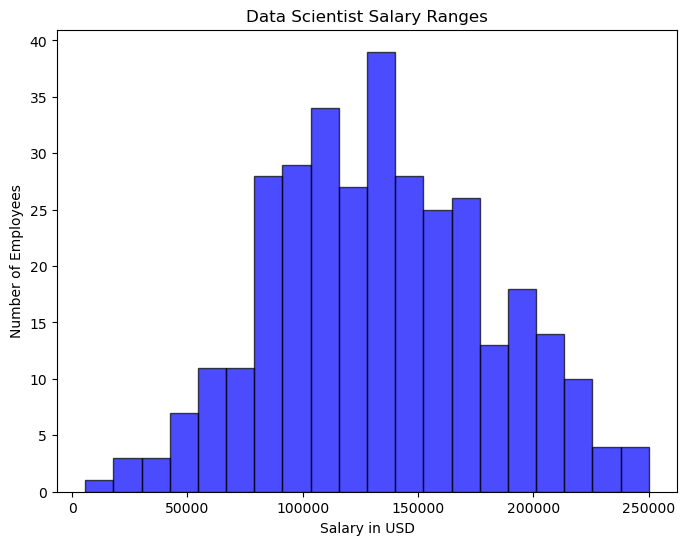

In [9]:
num_bins = 20
plt.figure(figsize=(8,6))
plt.hist(cleaned_dataset['salary_in_usd'], bins=num_bins, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Salary in USD')
plt.ylabel('Number of Employees')
plt.title('Data Scientist Salary Ranges')
plt.show()

---
## Second Visualization
### Scatterplot of Experience vs. Salary
*There are only 4 unique values for experience: EN (entry), MI (middle), SE (senior), EX (expert). The important information is the regression line which shows a direct correlation between experience and salary.*

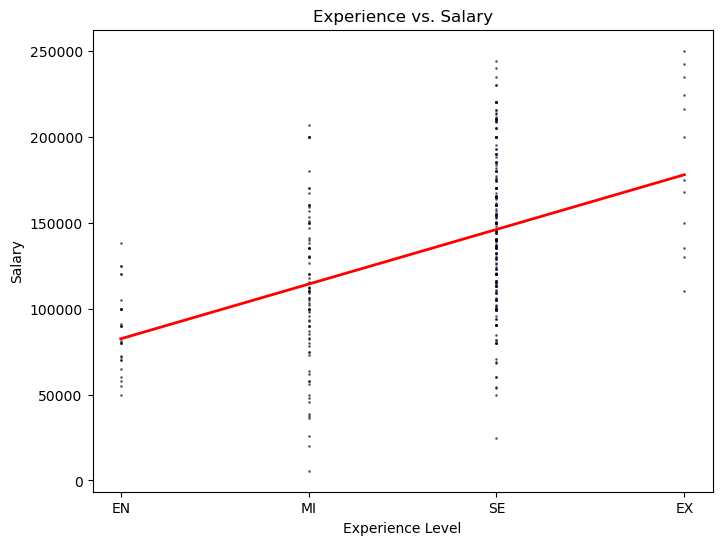

In [10]:
lvl_of_experience = {'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4}
cleaned_dataset_copy = cleaned_dataset.copy()
cleaned_dataset_copy['Level of Experience'] = cleaned_dataset_copy['experience_level'].map(lvl_of_experience)
plt.figure(figsize=(8, 6))
plt.scatter(cleaned_dataset_copy['Level of Experience'], cleaned_dataset_copy['salary_in_usd'], 
            alpha=0.5, color='blue', edgecolors='black', s=1)
plt.xlabel('Experience Level')
plt.ylabel('Salary')
plt.title('Experience vs. Salary')
plt.xticks([1, 2, 3, 4], ['EN', 'MI', 'SE', 'EX'])
least_squares_polynomial_fit = np.polyfit(cleaned_dataset_copy['Level of Experience'], 
                                          cleaned_dataset_copy['salary_in_usd'], 1)
regression_line = np.polyval(least_squares_polynomial_fit, [1, 2, 3, 4])
plt.plot([1, 2, 3, 4], regression_line, 'r', linewidth=2)
plt.show()

---
## Third Visualization
### Bar chart of average salary in different company sizes (small, medium, and large)
*Average is calculated from the cleaned dataset.*

This visualization shows almost no difference in pay between medium and large companies, but smaller companies have significantly less average pay.

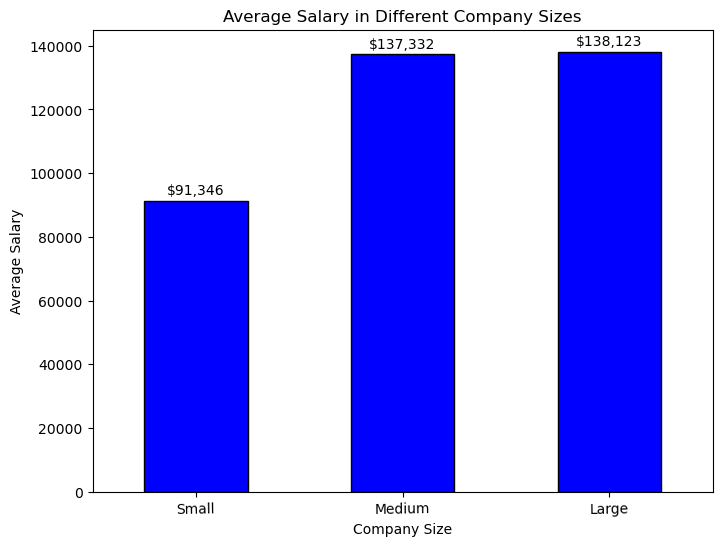

In [11]:
average_salaries = cleaned_dataset.groupby('company_size')['salary_in_usd'].mean().sort_values()
plt.figure(figsize=(8, 6))
bar_plot = average_salaries.plot(kind='bar', color='blue', edgecolor='black')
for idx, value in enumerate(average_salaries):
    formatted_value = '${:,.0f}'.format(value)
    bar_plot.text(idx, value + 1000, formatted_value, ha='center', va='bottom', color='black')
plt.xlabel('Company Size')
plt.ylabel('Average Salary')
plt.title('Average Salary in Different Company Sizes')
plt.xticks(range(len(average_salaries)), ['Small', 'Medium', 'Large'], rotation=1)
plt.show()

---
### Multiple linear regression model

*This model features multiple variables. There is an accuracy measure with the MSE score (mean squared error) and the R2 score (r-squared). These are fairly low scores, so this model is not very accurate, but it will scale and gain accuracy with more data. 330 entries (even 600 entries) is not enough to be very accurrate, but it provides a base that can easily be improved with more data.*

In [12]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
intercept = model.intercept_

print("Intercept:", intercept)
print("Coefficients:")
print(coefficients)

Mean Squared Error: 1608345258.880597
R-squared: 0.15752361449713548
Intercept: 5.4382908562745306e+17
Coefficients:
                  Feature   Coefficient
0               work_year  3.312847e+03
1     experience_level_EN  5.085750e+17
2     experience_level_EX  5.085750e+17
3     experience_level_MI  5.085750e+17
4     experience_level_SE  5.085750e+17
5   employee_residence_BG -9.432566e+16
6   employee_residence_BO -9.432566e+16
7   employee_residence_BR -9.432566e+16
8   employee_residence_CA -9.432566e+16
9   employee_residence_DE -9.432566e+16
10  employee_residence_ES -9.432566e+16
11  employee_residence_FR -9.432566e+16
12  employee_residence_GR -9.432566e+16
13  employee_residence_HU -9.432566e+16
14  employee_residence_IN -9.432566e+16
15  employee_residence_IT -9.432566e+16
16  employee_residence_MY -9.432566e+16
17  employee_residence_PH -9.432566e+16
18  employee_residence_PR -9.432566e+16
19  employee_residence_PT -9.432566e+16
20  employee_residence_RO -9.432566e+16
21 

---
### The following code provides a frame of reference for the accuracy of the data. 
*Changing the random seed will yield different data points but similar accuracy.*

In [13]:
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
result_df['Difference'] = result_df['Actual'] - result_df['Predicted']
result_df['Actual'] = result_df['Actual'].map("${:,.0f}".format)
result_df['Predicted'] = result_df['Predicted'].map("${:,.0f}".format)
result_df['Difference'] = result_df['Difference'].map("${:,.0f}".format)
print("Frame of Reference for Test Set Predictions:")
print(result_df.head(20))  

Frame of Reference for Test Set Predictions:
       Actual Predicted Difference
206  $200,000  $166,464    $33,536
170  $170,000  $131,712    $38,288
540  $115,934  $145,152   $-29,218
577  $150,075  $145,152     $4,923
302  $146,000  $145,152       $848
407  $183,600  $169,792    $13,808
323  $180,000  $170,368     $9,632
305   $99,000  $145,728   $-46,728
570  $210,000  $145,152    $64,848
556  $145,000  $145,152      $-152
604  $129,000  $145,728   $-16,728
465  $120,000   $79,552    $40,448
103   $62,000  $132,224   $-70,224
341   $93,700  $145,152   $-51,452
484  $210,000  $145,152    $64,848
582  $220,110  $145,152    $74,958
256  $200,000  $131,712    $68,288
372  $164,996  $145,728    $19,268
454  $125,000   $80,064    $44,936
555  $160,000  $145,152    $14,848


---
### User Interface
*Select options from the slider and dropdowns, then click the "Predict Salary" button.

In [14]:
def create_dropdown_widget(column_values, description):
    unique_values = sorted(column_values.unique())
    dropdown_widget = widgets.Dropdown(options=unique_values, value=unique_values[0], description=description, style=style)
    return dropdown_widget


style = {'description_width': 'initial'}

work_year_widget = widgets.IntSlider(value=2024, min=2023, max=2025, step=1, description='Work Year:', style=style)
experience_level_widget = widgets.Dropdown(options=['EN', 'MI', 'SE', 'EX'], value='EN', 
                                           description='Experience Level: (EN)try, (MI)d, (SE)nior, (EX)pert', style=style)
employee_residence_widget = create_dropdown_widget(cleaned_dataset['employee_residence'], 
                                                   description='Employee Residence: (alpha-2 code)')
remote_ratio_widget = create_dropdown_widget(cleaned_dataset['remote_ratio'], description='Remote Ratio (%):')
company_size_widget = widgets.Dropdown(options=['S', 'M', 'L'], value='S', description='Company Size: (S)mall, (M)edium, (L)arge', style=style)
employment_type_widget = widgets.Dropdown(options=['FT', 'CT', 'FL'], value='FT', 
                                          description='Employment Type: (FT) Full Time, (CT) Contract, (FL) Freelance', style=style)

experience_level_widget.layout.width = '40%'
employee_residence_widget.layout.width = '40%'
remote_ratio_widget.layout.width = '40%'
company_size_widget.layout.width = '40%'
employment_type_widget.layout.width = '40%'

output_widget = widgets.Output(layout={'border': '1px solid black'})

predict_button = widgets.Button(description='Predict Salary')

with output_widget:
        print('Predicted Salary:')
        
def on_predict_button_click(b):
    with output_widget:
        output_widget.clear_output()
        work_year = work_year_widget.value
        experience_level = experience_level_widget.value
        employee_residence = employee_residence_widget.value
        remote_ratio = remote_ratio_widget.value
        company_size = company_size_widget.value
        employment_type = employment_type_widget.value
        
        user_input = pd.DataFrame({
            'work_year': [work_year],
            'experience_level': [experience_level],
            'employee_residence': [employee_residence],
            'remote_ratio': [remote_ratio],
            'company_size': [company_size],
            'employment_type': [employment_type]
        })
        
        user_input = pd.get_dummies(user_input, columns=['experience_level', 'employee_residence', 'remote_ratio', 
                                                         'company_size', 'employment_type'])
        missing_columns = set(X.columns) - set(user_input.columns)
        for col in missing_columns:
            user_input[col] = False
        common_columns = list(set(X.columns) & set(user_input.columns))
        columns_sorted = sorted(common_columns, key=lambda x: X.columns.get_loc(x))    
        user_input_sorted = user_input[columns_sorted]
        
        predicted_salary = model.predict(user_input_sorted)[0]
        
        print(f'Predicted Salary: ${predicted_salary:,.0f}')
        
predict_button.on_click(on_predict_button_click)
        
input_widgets = [work_year_widget, experience_level_widget, employee_residence_widget, remote_ratio_widget, company_size_widget, 
                 employment_type_widget]

input_box = widgets.VBox(input_widgets, layout=widgets.Layout(display='flex', flex_flow='column', align_items='stretch', margin='0 0 30px 0'))

button_box = widgets.VBox([predict_button], layout=widgets.Layout(display='flex', flex_flow='column', align_items='stretch', margin='0 0 30px 0'))

layout = widgets.VBox([input_box, button_box, output_widget], 
                              layout=widgets.Layout(display='flex', flex_flow='column', align_items='stretch', padding='10px'))

display(layout)